## **Assignment Three (EECS3405 F25)**

**your name (your student number):** Simon Posluns (221541727)

**your yorku email:** simonp22@my.yorku.ca

This assignment is mainly for you to review review neural networks and deep learning models. You have to work individually. Remember to fill in your information (name, student number, email) at above.


##**What to Submit**

Use **one** notebook file (*.ipynb*) for **each** question, which should contain all of your answers and codes. You must zip all three notebooks into one zip file to submit it onto eClass.
No late submission will be accepted.

* For all written parts, write your answers in text cells. To avoid confusions in marking, better to embed latex codes there to represent all mathematical notations and equations.  No handwriting is accepted.

* For programming parts, you should give codes, comments, explanations and the proper running outputs in both code and text cells. Make your jupyter notebook clean and concise. Remove all unused codes and all intermediate results from the submitted notebook. The submitted notebook should include only the final (best) outputs for each question. Also make sure every code cell runnable so that markers can reproduce the outputs if necessary.

### **Q1** (20 marks) **Matrix Factorization for Collaborative Filtering**

We investigate matrix factorization for collaborative filtering using [the MovieLens 100K dataset]( https://grouplens.org/datasets/movielens/100k/), which contains 100,000 ratings provided by 943 users on 1,682 movies.
In this question, you will first follow the given code to download the MovieLens 100K ratings and load them into a Python sparse matrix. After that, refer to [this matrix factorization implementation](https://colab.research.google.com/drive/1WVEKcaHB858WsdmjQ1MOjyH2G92TDveF) to factorize the user–movie rating matrix for recommendation purposes (do NOT use `jax.grad` here).
Once the factorization is complete, use the cosine similarity between movie vectors, defined as

$$
\text{sim}(\mathbf{v}_i,\mathbf{v}_j) = \frac{\mathbf{v}_i \cdot \mathbf{v}_j}{\Vert \mathbf{v}_i \Vert \Vert \mathbf{v}_j \Vert}
$$
to measure the similarity between different movies.

As an example, you may recommend the top three most similar movies for each of the following movie IDs:

$$
\Big\{0, 94, 250, 379, 784, 863, 1044, 1141, 1203, 1445 \Big\}
$$

You may refer to [the movie list](http://www.cs.yorku.ca/~huijiang/ml-100k/u.item) for the corresponding movie titles.
(Note: the indexes in the list start from 1, not 0.)

*   Use both Stochastic Gradient Descent (SGD) and the Alternating algorithm for matrix factorization. Compare their performance in terms of training speed and recommendation quality.
* Evaluate how the movie vector dimension size $k=10, 30, 100$
affects both the training efficiency and the quality of recommendations.






In [ ]:
## Preparation code to download the data and load them into a sparse matrix
##
import pandas as pd
import numpy as np
import gdown
from scipy.sparse import csr_matrix
import time
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# 1. Download and unzip the dataset first
#    URL: https://files.grouplens.org/datasets/movielens/ml-100k.zip
#    Then point to the u.data file inside the unzipped folder.
#!wget -O ml-100k.zip https://files.grouplens.org/datasets/movielens/ml-100k.zip
#!unzip -o -q ml-100k.zip
#path = "ml-100k/u.data"

##download from google drive
#url = 'https://drive.google.com/file/d/12cpRJ2977nyqUSiUMkvdRS9OtYy6Fj_P/view?usp=share_link'
#path = 'u.data'
#gdown.download(url, path, quiet=False,fuzzy=True)

# download from YorkU server
!wget -q -r -np -nH --cut-dirs=1 -R "index.html*" http://www.cs.yorku.ca/~huijiang/ml-100k/
path = "ml-100k/u.data"

# The raw file is tab-separated: user_id, item_id, rating, timestamp

df = pd.read_csv(path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# 2. Convert IDs to 0-based indices (good for matrix indexing)
df['user_id'] = df['user_id'].astype('category')
df['item_id'] = df['item_id'].astype('category')

n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()

print(f"Users: {n_users}, Items: {n_items}, Ratings: {len(df)}")

# 3. Build a sparse user–item rating matrix (CSR format)
# Rows \u2192 users, Columns \u2192 items, Values \u2192 ratings
X = csr_matrix(
    (df['rating'].astype(float),
     (df['user_id'].cat.codes, df['item_id'].cat.codes)),
    shape=(n_users, n_items)
)

print(X.shape)

df_matrix = pd.DataFrame.sparse.from_spmatrix(X)
display(df_matrix)

print(df.columns)

df.head()

### Alternating Algorithm for Matrix Factorization (Algorithm 7.6 on page 145)
###
# X: a sparse matrix (scipy.sparse.csr_matrix)
# k: size for dense vectors
def Alternating_MF(X, k=10, lambda1=0.1, lambda2=0.1, max_epoch=10):
  # initialize U and V
  U = 0.01*np.random.normal(size =(X.shape[0], k))
  V = 0.01*np.random.normal(size =(X.shape[1], k))
  n = X.count_nonzero()       # number of training samples

  loss = loss_fun_vec(U, V, X, lambda1, lambda2)
  print(f'epoch = 0: loss = {loss}')

  for ep in range(max_epoch):
    for i in range(X.shape[0]):
      X_row = X.getrow(i)     # extract i-th row in X
      ind = X_row.nonzero()   # get 1st, 2nd indices for i-th col in X
      V_s = V[ind[1],:]
      U[i,:] = np.transpose(np.linalg.inv(V_s.T @ V_s + lambda1 * np.identity(k) * n/U.size) @ V_s.T @ X_row[ind[0],ind[1]].T)

    for j in range(X.shape[1]):
      X_col = X.getcol(j)     # extract j-th col in X
      ind = X_col.nonzero()   # get 1st, 2nd indices for i-th col in X
      U_s = U[ind[0],:]
      V[j,:] = np.transpose(np.linalg.inv(U_s.T @ U_s + lambda2 * np.identity(k) * n/V.size) @ U_s.T @ X_col[ind[0],ind[1]].T)

    loss = loss_fun_vec(U, V, X, lambda1, lambda2)
    print(f'epoch = {ep+1}: loss = {loss}')

  return U,V


# vectorized version of loss function Q(U,V) as above
# X: a sparse matrix (scipy.sparse.csr_matrix)
# U,V: both dense matrices (X = U @ V.T)
def loss_fun_vec(U, V, X, lambda1=0.1, lambda2=0.1):
  ind = X.nonzero()
  diff = np.sum(U[ind[0],:]*V[ind[1],:],axis=1) - np.array(X[ind[0],ind[1]]).squeeze()
  loss = np.mean(diff*diff)
  loss += lambda1*np.sum(U*U)/U.size + lambda2*np.sum(V*V)/V.size
  return loss

#learning rate
def SGD_MF(X, k=10, lr=0.01, lambda1=0.005, lambda2=0.005, max_epoch=10, batch_size=100):

    U = 0.1*np.random.normal(size=(X.shape[0], k))
    V = 0.1*np.random.normal(size=(X.shape[1], k))

    n = X.count_nonzero()
    loss = loss_fun_vec(U, V, X, lambda1, lambda2)
    print(f'epoch = 0: loss = {loss}')

    for epoch in range(max_epoch):
        indices = list(zip(*X.nonzero()))
        np.random.shuffle(indices)

        # iterate over batches
        for start in range(0, len(indices), batch_size):
            batch = indices[start:start + batch_size]

            # accumulate gradients over the batch
            grad_U = np.zeros_like(U)
            grad_V = np.zeros_like(V)

            for i, j in batch:
                e_ij = X[i, j] - U[i, :] @ V[j, :].T
                grad_U[i, :] += e_ij * V[j, :] - lambda1 * U[i, :]
                grad_V[j, :] += e_ij * U[i, :] - lambda2 * V[j, :]

            # apply average gradient for the batch
            U += lr * grad_U
            V += lr * grad_V

        lr *= 0.95
        loss = loss_fun_vec(U, V, X, lambda1, lambda2)
        print(f'epoch = {epoch+1}: loss = {loss}')

    return U, V

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def find_similar_movies(movie_id, V, k=3):
    target_vector = V[movie_id, :]
    similarities = []

    for i in range(V.shape[0]):
        if i != movie_id:
            sim = cosine_similarity(target_vector, V[i, :])
            similarities.append((i, sim))

    # descending order sort
    similarities.sort(key=lambda x: x[1], reverse=True)

    #return top k similarities
    return similarities[:k]

def load_genre_data(path='ml-100k/u.item'):
    genre_cols = ['unknown', 'Action', 'Adventure', 'Animation', 'Children',
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
    'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
    'Sci-Fi', 'Thriller', 'War', 'Western']

    movie_df = pd.read_csv(path, sep='|', encoding='latin-1', header=None)
    movie_id = movie_df[0]
    genres = movie_df.iloc[:, 5:24]
    genres.columns = genre_cols

    genre_dict = {}
    for idx, row in genres.iterrows():
        movie_genres = [genre for genre, value in row.items() if value == 1]
        genre_dict[movie_id[idx]] = movie_genres

    return genre_dict

# Load movie titles
movie_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                       header=None, usecols=[0, 1], names=['movie_id', 'title'])
movie_titles = movie_df.set_index('movie_id')['title'].to_dict()

test_movie_ids = [28, 81, 126, 131, 153, 172, 178, 179, 269, 342]


genre_dict = load_genre_data()
print("\n")



# alternating matrix factorization
for k_dim in [10, 15, 20, 30, 40, 50, 100]:
    print(f"\nRunning Alternating MF with k={k_dim}\n")
    start_time = time.time()
    U, V = Alternating_MF(X, k=k_dim, lambda1=0.1, lambda2=0.1, max_epoch=10)
    training_time = time.time() - start_time
    print(f"\nTraining time: {training_time:.2f} seconds")
    print(f"Top 3 Similar Movies for Each Test Movie (k={k_dim})\n")

    for movie_id in test_movie_ids:
        mid = movie_id + 1  # convert to 1-based ID
        movie_title = movie_titles.get(mid, "Unknown")
        movie_genres = ", ".join(genre_dict.get(mid, [])) or "Unknown"

        print(f"\nMovie {movie_id} (ID {mid}): {movie_title}  "
              f"(Genres: {movie_genres})")

        similar_movies = find_similar_movies(movie_id, V, k=3)
        for rank, (sim_id, similarity) in enumerate(similar_movies, 1):
            smid = sim_id + 1
            sim_title = movie_titles.get(smid, "Unknown")
            sim_genres = ", ".join(genre_dict.get(smid, [])) or "Unknown"

            print(f"  {rank}. Movie {sim_id} (ID {smid}): {sim_title}  "
                  f"(Genres: {sim_genres})  "
                  f"(similarity: {similarity:.4f})")



print("\n")

# Stochastic Gradient Descent Matrix factorization
for k_dim in [10, 30, 50, 100]:
    print(f"\nRunning SGD MF with k={k_dim}\n")
    start_time = time.time()
    U, V = SGD_MF(X, k=k_dim, lr=0.01, lambda1=0.01, lambda2=0.01, max_epoch=20, batch_size=100)
    training_time = time.time() - start_time
    print(f"\nTraining time: {training_time:.2f} seconds")
    print(f"Top 3 Similar Movies for Each Test Movie (k={k_dim})\n")

    for movie_id in test_movie_ids:
        mid = movie_id + 1
        movie_title = movie_titles.get(mid, "Unknown")
        movie_genres = ", ".join(genre_dict.get(mid, [])) or "Unknown"

        print(f"\nMovie {movie_id} (ID {mid}): {movie_title}  "
              f"(Genres: {movie_genres})")

        similar_movies = find_similar_movies(movie_id, V, k=3)
        for rank, (sim_id, similarity) in enumerate(similar_movies, 1):
            smid = sim_id + 1
            sim_title = movie_titles.get(smid, "Unknown")
            sim_genres = ", ".join(genre_dict.get(smid, [])) or "Unknown"

            print(f"  {rank}. Movie {sim_id} (ID {smid}): {sim_title}  "
                  f"(Genres: {sim_genres})  "
                  f"(similarity: {similarity:.4f})")






Users: 943, Items: 1682, Ratings: 100000
(943, 1682)


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,0,0,0,0,0,0,0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0,0,0,0,0,0,0,0,5.0,0,...,0,0,0,0,0,0,0,0,0,0
939,0,0,0,2.0,0,0,4.0,5.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
940,5.0,0,0,0,0,0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object')



Running Alternating MF with k=10

epoch = 0: loss = 13.727060477317755
epoch = 1: loss = 3.810308605313195
epoch = 2: loss = 0.7195658246404677
epoch = 3: loss = 0.6538622032143963
epoch = 4: loss = 0.631982172145617
epoch = 5: loss = 0.6203452658049178
epoch = 6: loss = 0.6127806717033566
epoch = 7: loss = 0.6074003546617032
epoch = 8: loss = 0.603328827414795
epoch = 9: loss = 0.6001107332614734
epoch = 10: loss = 0.5975069654172172

Training time: 14.55 seconds
Top 3 Similar Movies for Each Test Movie (k=10)


Movie 28 (ID 29): Batman Forever (1995)  (Genres: Action, Adventure, Comedy, Crime)
  1. Movie 682 (ID 683): Rocket Man (1997)  (Genres: Comedy)  (similarity: 0.9576)
  2. Movie 554 (ID 555): White Man's Burden (1995)  (Genres: Drama)  (similarity: 0.9334)
  3. Movie 382 (ID 383): Flintstones, The (1994)  (Genres: Children, Comedy)  (similarity: 0.9206)

Movie 81 (ID 82): Jurassic Park (1993)  (Genres: Act

**Q1 Discussion:**

Here we use collaborative filtering to determine similarity between movies based on the premise that when comparing two films, if multiple users like one film they will most likely like the other. Rather than using the original sample list, I chose a selection of ten films I had seen as I was interested in verifying based on my own preferences whether the cosine similarity resulted in plausible results.

When looking at the output created by the Alternating Algorithm for Matrix Factorization, we observe that by including more latent features (higher value of *k*), it seemed to both produce less plausible results

This can be attributed to the fact that a high cosine between two movie vectors just means the model found those two columns pointing in nearly the same direction. But does this accurately depict the viewer's preferences? Not necessarily, as this could be caused by a few shared raters or by noise. Thus overfitting is generally a problem in collaborative filtering models based upon sparsely populated data input.

Also including the genres of the films was useful in this analysis. An example comparison of one film at k=10 and 40 (both using the alternating algorithm):

**k=10**

Movie 178 (ID 179): Clockwork Orange, A (1971)  (Genres: Sci-Fi)
  1. Movie 1352 (ID 1353): 1-900 (1994)  (Genres: Romance)  (similarity: 0.8716)
  2. Movie 1142 (ID 1143): Hard Eight (1996)  (Genres: Crime, Thriller)  (similarity: 0.8613)
  3. Movie 1523 (ID 1524): Kaspar Hauser (1993)  (Genres: Drama)  (similarity: 0.8486)

**k=40**

Movie 178 (ID 179): Clockwork Orange, A (1971)  (Genres: Sci-Fi)
  1. Movie 474 (ID 475): Trainspotting (1996)  (Genres: Drama)  (similarity: 0.5654)
  2. Movie 134 (ID 135): 2001: A Space Odyssey (1968)  (Genres: Drama, Mystery, Sci-Fi, Thriller)  (similarity: 0.5501)
  3. Movie 36 (ID 37): Nadja (1994)  (Genres: Drama)  (similarity: 0.5371)


When we provide recommendations for the same movie, A Clockwork Orange, at k =40 we see that it also recommends 2001: A Space Odyssey which is by the same director (Stanley Kubrick), which substantiates the idea that it is providing a greater accuracy of viewer preference predictions.


With Larger k values, it can be observed that the cosine similarity is a smaller value but the top few movies actually correlated better overall to reality. In the second example, the similar movies are all drama and/or sci-fi which makes sense as the reference movie itself is serious and science fiction. Compared to when k=10, we see that it is compared to movies that are less serious albeit with a higher cosine similarity. Thus cosine similarity in terms of proximity to a perfect fit of 1.0 (vectors pointing in the exact same direction) should be a desired metric when designing a collaborative filtering model. Rather, an appropriately balanced number of iterations which allows the highest cosine similarities to depict a more accurate comparison.

**General Observations:**

*   ALS converged faster than SGD when the value of k is smaller
*   SGD tends to overfit more and the results do not reflect a human comparison
*   Both algorithms overfit the training data as k became higher
*   As k was increased (higher latent features), the Alternating Algorithm results became very influenced by noise whereas at lower values only the most vital trends were captured

In terms of training efficiency, the Alternating Algorithm tends to converge in fewer epochs for smaller latent dimensions, making it faster per recommendation in low-dimensional spaces. However, it becomes computationally expensive as the latent dimension k increases. In contrast, SGD scales linearly with the number of non-zero ratings and latent features, allowing updates on subsets of data (batches), making it more suitable for large sparse datasets.
SGD proved to not be very useful in smaller k values and needed approximately 50 to provide better recommendations. Ultimately, I would recommend SGD for larger data sets (especially when they are sparse), and ALS for smaller data sets that are well-populated for more accurate results.


**Alternating Least Squares (ALS / Alternating MF):**

Factorizes X $ ≈ UV^\top$ with latent dimension k.
Iteratively updates user vectors U and movie vectors V to minimize squared error.


**Applying Stochastic Gradient Descent (SGD) to matrix factorization: **

If we consider the total error function (with no regularization):

$$Q(U,V) = \sum_{(i,j) \in \Omega} \left( x_{ij} - u_i^\top v_j \right)^2$$

We can apply this to SGD by only considering one value in the residual matrix:

$$ e_(i,j) = \left( x_{ij} - u_i^\top v_j \right)$$

The loss for a single entry is:

$$L_{ij} = \frac{1}{2} \left( x_{ij} - u_i^\top v_j \right)^2$$

The gradients with respect to the user and item vectors are:

$$\frac{\partial L_{ij}}{\partial u_i} = \frac{\partial}{\partial u_i} \frac{1}{2} \left(x_{ij} - u_i^\top v_j \right)^2 $$

$$ = \left (x_{ij} - u_i^\top v_j \right) \frac {\partial}{\partial u_i} \left(x_{ij} - u_i^\top v_j \right ) $$
$$ = - \left (x_{ij} - u_i^\top v_j \right) v_j $$

or, as written with "e" for error:

$$ = - \left (e_{ij}  \right) v_j $$

and:

$$\frac{\partial L_{ij}}{\partial v_j} = - \left (x_{ij} - u_i^\top v_j \right) u_j $$
$$ = - \left (e_{ij}  \right) u_j $$

Then we update the vectors using a learning rate η:

$$u_i \gets u_i + \eta \, e_{ij} \, v_j, \quad
v_j \gets v_j + \eta \, e_{ij} \, u_i $$


### **Q2** (20 marks) **Deep Neural Networks for nonlinear feature extraction**


Based on [the implementation of fully-connected deep neural networks at Colab](https://colab.research.google.com/drive/1dznpn8zYNTyuLp0XP1tKetoB7i8XbKV0), implement a nonlinear feature extraction method using deep neural networks:

*   Bottleneck features (Section 4.4.2)

for the MNIST data.

Use all training data of 10 digits to train these the Bottleneck feature extractor and  investigate various network structures (such as different number of layers and nodes per layer) for the best possible classification performance. When you measure the classification performance, please use the best
 `scikit-learn` nonlinear SVM (Gaussian kernel) code as you did in **Assignment 2** to implement a binary classifier on the extracted features of the training data of two digits ('7' vs. '9').

 At last,  report the best configuration and its corresponding classification accuracy in the heldout test images for two pairs of digits ('7' vs. '9' and '0' vs. '8').
Discuss your findings in experiments.


epoch=0 lr=0.0100 loss=0.15853 accuracy=95.39%
epoch=1 lr=0.0090 loss=0.09776 accuracy=97.15%
epoch=2 lr=0.0081 loss=0.06917 accuracy=98.11%
epoch=3 lr=0.0073 loss=0.05133 accuracy=98.65%
epoch=4 lr=0.0066 loss=0.04407 accuracy=98.77%
epoch=5 lr=0.0059 loss=0.03269 accuracy=99.17%
epoch=6 lr=0.0053 loss=0.02801 accuracy=99.30%
epoch=7 lr=0.0048 loss=0.02569 accuracy=99.43%
epoch=8 lr=0.0043 loss=0.01839 accuracy=99.66%
epoch=9 lr=0.0039 loss=0.01581 accuracy=99.74%
epoch=10 lr=0.0035 loss=0.01360 accuracy=99.80%
epoch=11 lr=0.0031 loss=0.01217 accuracy=99.84%
EVALUATING MLP PERFORMANCE
MLP validation accuracy (10-way classification): 98.05%
Training samples: 12214
Validation samples: 2037
Bottleneck feature dimension: 200
Results for 7 vs 9:
  C = 10, gamma = 0.001
  Training accuracy: 99.97%
  Validation accuracy: 99.31%
  Training time: 1.048s
Training samples: 11774
Validation samples: 1954
Bottleneck feature dimension: 200
Results for 0 vs 8:
  C = 0.1, gamma = 0.001
  Training acc

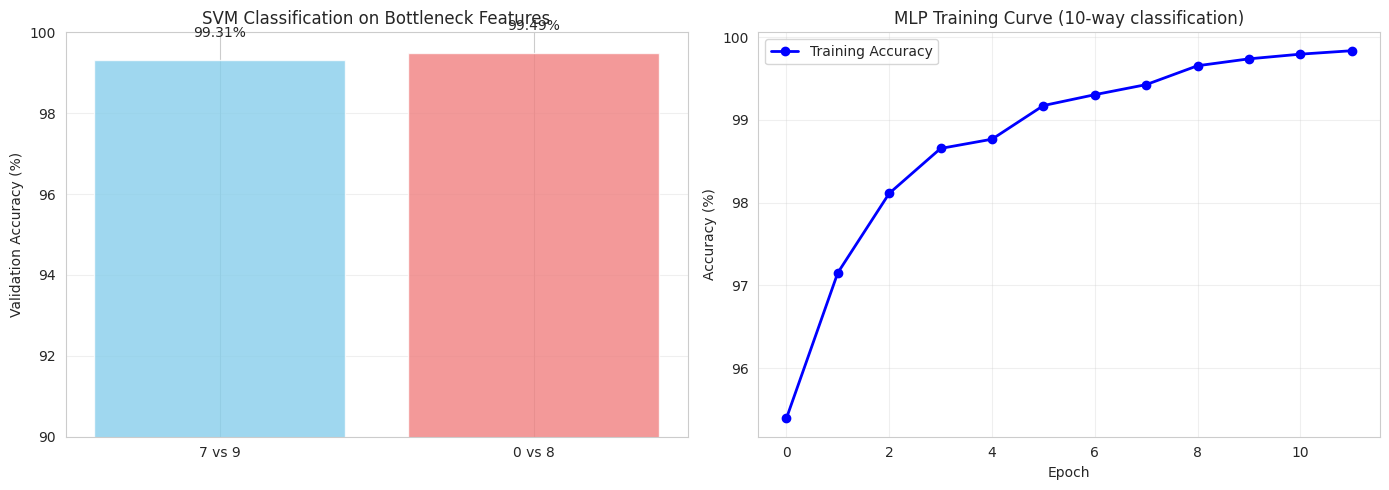

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax.nn as jnn
from jax import random, device_put
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time

# --- Load and preprocess MNIST ---
mnist_data = datasets.MNIST('data', train=True, download=True)
mnist_data = list(mnist_data)

# Useing full MNIST training set
mnist_train = list(datasets.MNIST('data', train=True, download=True))

# Use MNIST subset for testing
mnist_val = list(datasets.MNIST('data', train=False, download=True))


# Convert images to flattened arrays in [0,1]
def img_to_array(image):
    return np.array(image).reshape(-1) / 255.0

X_train = np.array([img_to_array(img) for img, lbl in mnist_train])
y_train = np.array([lbl for img, lbl in mnist_train])
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train] = 1  # one-hot encoding

X_val = np.array([img_to_array(img) for img, lbl in mnist_val])
y_val = np.array([lbl for img, lbl in mnist_val])
Y_val = np.zeros((y_val.size, 10))
Y_val[np.arange(y_val.size), y_val] = 1

class myMLP2():
    def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',
                 loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,
                 init_range=1.0, annealing=1.0):
        self.optimizer = optimizer
        self.lr = lr
        self.annealing = annealing
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.debug = debug
        self.activation = activation
        self.loss = loss
        self.random_state = random_state
        self.init_range = init_range
        self.struct = struct

    def initialization(self, X, Y):
        key = random.PRNGKey(self.random_state)
        input_dim = X.shape[1]
        self.layers = len(self.struct)
        self.W_b = [0]*(self.layers+1)
        self.W_b_grad = [0]*(self.layers+1)

        for l in range(self.layers):
            output = self.struct[l]
            self.W_b[l] = device_put(4.90*(random.uniform(key,(input_dim+1, output))-0.5)*
                                     self.init_range/jnp.sqrt(output+input_dim))
            self.W_b_grad[l] = device_put(jnp.zeros((input_dim+1, output)))
            input_dim = output

        output = Y.shape[1]
        self.W_b[self.layers] = device_put(4.90*(random.uniform(key,(input_dim+1, output))-0.5)*
                                           self.init_range/jnp.sqrt(output+input_dim))
        self.W_b_grad[self.layers] = device_put(jnp.zeros((input_dim+1, output)))
        return

    def forward(self, W_b, X, return_Z=False):
        Zs = [0]*(self.layers+2) if return_Z else [0]
        Z = jnp.hstack((X,jnp.ones((X.shape[0],1),dtype=X.dtype)))
        if return_Z:
            Zs[0] = Z

        for l in range(self.layers):
            Z = jnn.relu(Z @ W_b[l])
            Z = jnp.hstack((Z,jnp.ones((Z.shape[0],1),dtype=Z.dtype)))
            if return_Z:
                Zs[l+1] = Z

        l = self.layers
        y = jnn.softmax(Z @ W_b[l], axis=1)
        if return_Z:
            Zs[l+1] = y
        else:
            Zs[0] = y
        return Zs

    def backward(self, X, Y, Zs):
        l = len(Zs)-1
        e = Zs[l] - Y
        WG = jnp.einsum('bo,bi->bio', e, Zs[l-1])
        self.W_b_grad[l-1] = jnp.mean(WG,axis=0)

        for l in range(self.layers,0,-1):
            e = ( e @ self.W_b[l].T ) * jnp.heaviside(Zs[l],0)
            e = jnp.delete(e, -1, axis=1)
            WG = jnp.einsum('bo,bi->bio', e, Zs[l-1])
            self.W_b_grad[l-1] = jnp.mean(WG,axis=0)
        return

    def loss_ce_batch(self, W_b, X, Y):
        R = self.forward(W_b, X, return_Z=False)
        return -jnp.mean(jnp.log(R[0][Y==1]+1e-8))

    def sgd(self, X, Y):
        n = X.shape[0]
        lr = self.lr
        errorsA = np.zeros(self.max_epochs)
        errorsC = np.zeros(self.max_epochs)

        for epoch in range(self.max_epochs):
            indices = np.random.permutation(n)
            for batch_start in range(0, n, self.batch_size):
                X_batch = X[indices[batch_start:batch_start+self.batch_size]]
                Y_batch = Y[indices[batch_start:batch_start+self.batch_size]]

                Zs = self.forward(self.W_b, X_batch, return_Z=True)
                self.backward(X_batch, Y_batch, Zs)

                for l in range(self.layers+1):
                    self.W_b[l] -= lr * self.W_b_grad[l]

            errorsC[epoch] = self.loss_ce_batch(self.W_b, X, Y)
            result = self.predict(X)
            errorsA[epoch] =  jnp.count_nonzero(jnp.equal(result, y_train))/y_train.size

            if self.debug:
                print(f'epoch={epoch} lr={lr:.4f} loss={errorsC[epoch]:.5f} accuracy={100*errorsA[epoch]:.2f}%')

            lr *= self.annealing
        return errorsA, errorsC

    def fit(self, X, Y):
        self.initialization(X, Y)
        X2 = device_put(X)
        Y2 = device_put(Y)
        errorsA, errorsC = self.sgd(X2, Y2)
        return errorsA, errorsC

    def predict(self, X):
        X2 = device_put(X)
        Y = self.forward(self.W_b, X2)
        return jnp.argmax(Y[0], axis=1)

mlp = myMLP2(struct=[800, 400, 200], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.01 )


errorsA, errorsC = mlp.fit(X_train, Y_train)

#layer_index=None , change to specified layer
def extract_bottleneck_features(mlp, X, layer_index=None):

    X2 = device_put(X)
    Zs = mlp.forward(mlp.W_b, X2, return_Z=True)

    # default is last hidden layer (if unspecified)
    if layer_index is None:
        layer_index = mlp.layers  # same as before

    bottleneck = Zs[layer_index][:, :-1]
    return np.array(bottleneck)


def evaluate_svm_on_digit_pair(mlp, digit_pair, X_train, y_train, X_val, y_val, C, gamma):

    #uses mask to select only specified pair for training
    mask_train = np.isin(y_train, digit_pair)
    X_train_pair = X_train[mask_train]
    y_train_pair = y_train[mask_train]

    # same for testing
    mask_val = np.isin(y_val, digit_pair)
    X_val_pair = X_val[mask_val]
    y_val_pair = y_val[mask_val]

    print(f"Training samples: {X_train_pair.shape[0]}")
    print(f"Validation samples: {X_val_pair.shape[0]}")

    # Extract bottleneck features
    bottleneck_train = extract_bottleneck_features(mlp, X_train_pair)
    bottleneck_val = extract_bottleneck_features(mlp, X_val_pair)

    print(f"Bottleneck feature dimension: {bottleneck_train.shape[1]}")

    # Standardize features
    scaler = StandardScaler()
    bottleneck_train_scaled = scaler.fit_transform(bottleneck_train)
    bottleneck_val_scaled = scaler.transform(bottleneck_val)

    # Convert labels to binary classification (+1, -1)
    y_train_binary = np.where(y_train_pair == digit_pair[0], 1, -1)
    y_val_binary = np.where(y_val_pair == digit_pair[0], 1, -1)

    # Use specified hyperparameters for C and gamma
    start = time.time()

    svm = SVC(kernel='rbf', C=C, gamma=gamma)
    svm.fit(bottleneck_train_scaled, y_train_binary)

    train_pred = svm.predict(bottleneck_train_scaled)
    val_pred = svm.predict(bottleneck_val_scaled)

    train_acc = np.mean(train_pred == y_train_binary)
    val_acc = np.mean(val_pred == y_val_binary)
    end = time.time()

    print(f"Results for {digit_pair[0]} vs {digit_pair[1]}:")
    print(f"  C = {C}, gamma = {gamma}")
    print(f"  Training accuracy: {100*train_acc:.2f}%")
    print(f"  Validation accuracy: {100*val_acc:.2f}%")
    print(f"  Training time: {end - start:.3f}s")

    return {
        'C': C,
        'gamma': gamma,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'time': end - start
    }


# Evaluate MLP performance on validation set
print("EVALUATING MLP PERFORMANCE")
result = mlp.predict(X_val)
mlp_val_acc = 100.0 * jnp.count_nonzero(jnp.equal(result, y_val)) / y_val.size
print(f'MLP validation accuracy (10-way classification): {mlp_val_acc:.2f}%')

# Evaluate SVM on bottleneck features for digit pair 7 vs 9
result_79 = evaluate_svm_on_digit_pair(
    mlp, [7, 9], X_train, y_train, X_val, y_val, 10, 0.001)

# Evaluate SVM on bottleneck features for digit pair 0 vs 8
result_08 = evaluate_svm_on_digit_pair(
    mlp, [0, 8], X_train, y_train, X_val, y_val, 0.1, 0.001)

# Summary
print("FINAL SUMMARY")
print(f"\nMLP Architecture: {mlp.struct}")
print(f"Bottleneck dimension: {mlp.struct[-1]}")
print(f"MLP 10-way classification accuracy: {mlp_val_acc:.2f}%")

print(f"\nDigit pair 7 vs 9:")
print(f"  Best C: {result_79['C']}, gamma: {result_79['gamma']}")
print(f"  Validation accuracy: {100*result_79['val_acc']:.2f}%")

print(f"\nDigit pair 0 vs 8:")
print(f"  Best C: {result_08['C']}, gamma: {result_08['gamma']}")
print(f"  Validation accuracy: {100*result_08['val_acc']:.2f}%")



# plotting for visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparing results
digit_pairs = ['7 vs 9', '0 vs 8']
val_accs = [100*result_79['val_acc'], 100*result_08['val_acc']]

axes[0].bar(digit_pairs, val_accs, color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('SVM Classification on Bottleneck Features')
axes[0].set_ylim([90, 100])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(val_accs):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

# Learning curves from MLP training
epochs = np.arange(len(errorsA))
axes[1].plot(epochs, 100*errorsA, 'b-o', label='Training Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('MLP Training Curve (10-way classification)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

**Q2 Discussion:**

Initially I tried a simple two layer [500, 250] network, and then a deeper one with more neurons: [800, 600, 400, 200]. After performing a grid search at this stage with C_values = [0.1, 1, 10, 100] and gamma_values = [0.001, 0.01, 0.1, 1] I found overall gamma = 0.001 to be the best. From there, after an adjustment of the architecture to current layer values, [800, 400, 200], and another search of C in [0.1, 1, 10, 100], the result was that they were all pretty similar in terms of validation accuracy. Thus the difference in selecting C = 10 for 7 vs 9 and C=0.1 for 0 vs 8 is so slight that that it is reasonable to explain the difference to be simply from noise.

The improvement in the architecture in three layers versus the original two could be attributed to a more gradual bottleneck. This allowed the network to overall have a better feature extraction in that the aggressive two layer approach caused it to eliminate more important features earlier on. The optimal results from a smaller gamma size in this case could be attributed to individual examples having less impact on the training of the model and therefore avoiding overfitting.

Overall, I propose that the neural network was able to extract useful discriminatory features to make the task given to the SVM simpler to make the digit pairs more separable in the bottleneck space than in the original pixel space. This can be substantiated by the fact that the a linear model was able to 99.31% and 99.49%.

### **Q3** (20 marks)  **Convolutional Neural Networks (CNN) for image classification**

Refer to [the example in this Colab notebook](https://colab.research.google.com/drive/1yzqLh4YFIO_kXB0KnJdY69glnPmUCVfX), use `pytorch` to implement a CNN model as in Figure 8.23 on page 169 and evaluate it on the CIFAR10 data set. Vary the structures in this CNN model slightly to see whether you can further improve the performance on the *CIFAR10* test set. Report your best results and discuss your findings from experiments.

Refer to the following codes for how to load the *CIFAR10* data set.

Wed Dec  3 19:46:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             30W /   70W |     322MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

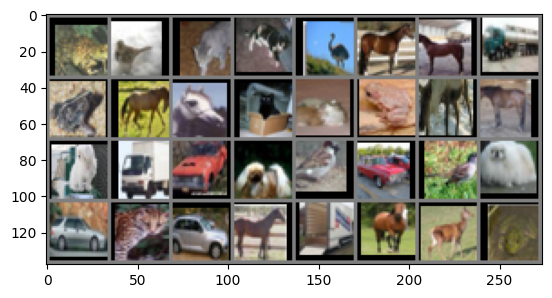

frog  bird  cat   cat   bird  horse horse truck frog  horse horse cat   cat   frog  deer  horse dog   truck car   dog   bird  car   bird  dog   car   cat   car   horse truck horse deer  frog 
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.351768
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.016660
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.080561
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.137677
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.978709
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.089159
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.029613
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.790920
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.012577
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.668490
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.916463
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.673969
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.693478
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.837099
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.706267
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.750924
Test set: Average

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import time
import torch.nn.functional as F

# checking for GPU:
!nvidia-smi

# function to preprocess cifar10 images
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # slight shift
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   ])


# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 32


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"number of images in the training set: {len(trainset)}")
print(f"number of images in the test set: {len(testset)}")
print(f"size of first image in the training set = {trainset[0][0].shape}, its label = {classes[trainset[0][1]]}")

# display images in the first batch and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# end of load data section
# model definition and implementation

#instantiating model:
#network = generate_model()

import torch.nn as nn

def generate_model():
    model = nn.Sequential(
        # --- Block 1 ---
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # maxpool brings down from 32 to 16

        # --- Block 2 ---
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # maxpool brings down from 16 to 8

        # --- Block 3 ---
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Uncommented: maxpool brings down from 8 to 4

        # --- Classifier ---
        nn.Flatten(),
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)

    )
    return model


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        #loss = F.nll_loss(torch.log(output + 1e-8), target)   # Use NLLLoss with log-probabilities
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum')
            pred = output.argmax(dim=1, keepdim=True)  # predicted class
            #test_loss += F.nll_loss(torch.log(output + 1e-8), target, reduction='sum').item()  # sum batch loss with log-probabilities
            #pred = output.argmax(dim=1, keepdim=True)  # predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100*accuracy:.2f}%)')
    return test_loss, accuracy

# checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = generate_model().to(device)

#learningRate = 0.0001
#decay = 1e-4
#SGD (with momentum), RMSprop, AdamW
#optimizer = optim.Adam(model.parameters(), lr=learningRate, weight_decay=decay)


optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9, weight_decay=5e-4)
#every 15 epochs, multiply learning rate by gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

train_losses, test_accuracies = [], []

epochs = 50

for epoch in range(1, epochs+1):
    train(model, device, trainloader, optimizer, epoch)
    test_loss, test_acc = test(model, device, testloader)

    #adding scheduler step
    scheduler.step()
    train_losses.append(test_loss)
    test_accuracies.append(test_acc)

model.eval()
with torch.no_grad():
    images, labels = next(iter(testloader))
    logits = model(images.to(device))
    probs = F.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)
    print("Predicted classes:", preds[:10])
    print("Probabilities:", probs[:10])


**Q3 Discussion**

Keeping the structure of the neural network exactly the same as can be seen on Figure 8.23 (page 169), the best accuracy I got to was about 76%. From there I proceeded to change a few things, first removing the line nn.Softmax(dim=1) at the end of the layer  and achieving the same softmax output but via the PyTorch cross_entropy() function in the test and train stages. I do not believe this affected the output accuracy but rather just made the processing of the training and testing stages faster (combining computation of negative log of the loss into one operation).

From there I updated the third layer of the neural network to have a 2x2 Maxpool, thus updating the classifier layer from nn.Linear(256*8*8, 4096) to nn.Linear(256*4*4, 512). This proved to be valuable in that by reducing the amount of memory capacity in the network, it forces the model to capture general ideas to avoid overfitting. At this point (keeping the Adam optimizer), I set the learning rate to 0.0001 adn the decay to 1e-4. This achieved 87% at epoch 30.

Subsequent tests did improve accuracy, albeit slowly. 89% at epoch 40 was achieved by changing from the Adam optimizer to SGD+momentum with the following hyperparameters and scheduler:

*   optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
*   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

The scheduler adjusted the learning rate every 15 epochs (step_size), it multiplied the learning rate by gamma. In this way, it helped avoid plateauing by having its incremental updates become progressively more precise.

Another modification was adding a BatchNorm() function at each layer, which causes the activations to have roughly mean 0 and standard deviation 1 at every batch.

91% at epoch 40 was achieved by adjusting the learning rate to 0.02 (up from 0.001). Further, 91.49% at epoch 50 by keeping the same settings previously but changing:

```
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # slight shift
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   ])
```

Data augmentation seemed to help in that by applying random transformations, it prompted the network to generalize more, further avoiding overfitting and becoming more accurate in its ability to idenify the target classifications based on general features.

With this last improvement I decided to try two more adjustments of the learning rate, first to 0.015 and then to 0.009. Both of these had about a 91% accuracy. Further increasing the epochs to 85 both did not result in any noticeable improvement; both learning rates maintaining about 91%.

Ultimately the changes that seemed to return the best results were those which decreased overfitting: namely, adding more randomization of the input (ie. transformations) to promote generalization, reducing the total memory via MaxPooling and reducing learning rate with longer epochs for fine-tuning of the final model weights (thus maximizing the results that had been generated earlier on). They key here with increasing the epochs is the scheduler to decrease the learning rate progressively; not doing so could result in a situation where you may "undo" some of the work done previously and have oscillation of your results rather than converging smoothly.